In [2]:
import pandas as pd
import numpy as np
import subprocess
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

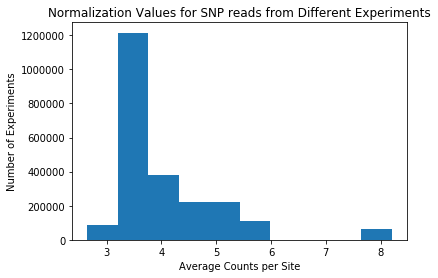

In [2]:
# concatenate all the bed files
# get normalization vlues for each bed file
first = True
norms = dict()
for file in os.listdir('/home/thouis/CTCF_variants/allele_counts'):
    temp = pd.read_table(os.path.join('/home/thouis/CTCF_variants/allele_counts', file))
    temp.columns = 'chr start variantID refAllele altAllele refCount altCount totalCount lowMAPQDepth lowBaseQDepth rawDepth otherBases improperPairs'.split()
    temp['norm'] = sum(temp['totalCount'])/len(temp['totalCount'])
    if first:
        snvs = temp
        first = False
    else:
        snvs = snvs.append(temp)
        
plt.hist(snvs['norm'])
plt.title('Normalization Values for SNP reads from Different Experiments')
plt.ylabel('Number of Experiments')
plt.xlabel('Average Counts per Site')
plt.show()

In [11]:
# add an 'end' column
snvs['end'] = snvs.start + 1

In [12]:
# write out one masive file
header = ['chr', 'start', 'end', 'refAllele',  'altAllele',  'refCount',  'altCount', 'norm']
snvs.to_csv('/home/kal/TF_models/data/SNVs/thouis_snvs/all_snvs.bed', sep='\t', columns = header, header=None, index=False)

In [8]:
# sort that file
command = ['sort', '-k1,1', '-k2,2n', '/home/kal/TF_models/data/SNVs/thouis_snvs/all_snvs.bed']
result = subprocess.run(command, stdout=open('/home/kal/TF_models/data/SNVs/thouis_snvs/all_snvs_sorted.bed', 'w'), stderr=subprocess.PIPE, universal_newlines=True)
print(result.returncode, result.stdout, result.stderr)

# merge the features
# bedtools merge -d -1 -c 4,5,6,7 -o distinct,distinct,sum,sum -i all_snvs_sorted.bed > all_snvs_merged.bed

0 None 


2294484


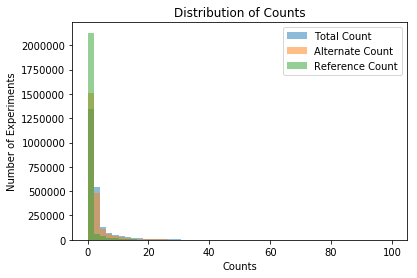

49157


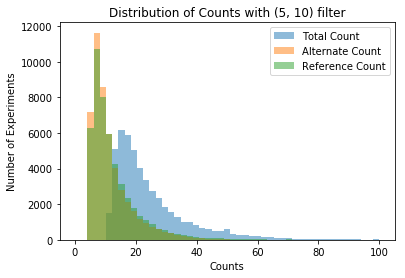

In [9]:
# gauge the dataset with some filters
print(len(snvs))
bins = np.linspace(0, 100, 50)
plt.hist(snvs['totalCount'], bins, alpha=0.5)
plt.hist(snvs['altCount'], bins, alpha=0.5)
plt.hist(snvs['refCount'], bins, alpha=0.5)
plt.legend(['Total Count', 'Alternate Count', 'Reference Count'])
plt.title('Distribution of Counts')
plt.ylabel('Number of Experiments')
plt.xlabel('Counts')
plt.show()

# gauge the dataset with some filters
cutoff=5
bothoff=10
filtered = snvs[(((snvs['altCount']>cutoff) & (snvs['refCount']>cutoff)) & (snvs['totalCount']>bothoff))]
print(len(filtered))
bins = np.linspace(0, 100, 50)
plt.hist(filtered['totalCount'], bins, alpha=0.5)
plt.hist(filtered['altCount'], bins, alpha=0.5)
plt.hist(filtered['refCount'], bins, alpha=0.5)
plt.legend(['Total Count', 'Alternate Count', 'Reference Count'])
plt.title('Distribution of Counts with (5, 10) filter')
plt.ylabel('Number of Experiments')
plt.xlabel('Counts')
plt.show()

In [3]:
# get the sorted file
snps = pd.read_table('/home/kal/TF_models/data/SNVs/thouis_snvs/all_snvs_sorted.bed', header=None)
snps.columns = ['chr', 'start', 'end', 'refAllele',  'altAllele',  'refCount',  'altCount', 'norm']

In [4]:
# merege the features but better
# only if > min_count reads on alternate allele for every individual experiment and the snp is the same
# HETEROZYGOUS only
min_count=5
both_count=10
ref_row = snps.iloc[0]
allele_to_n = {'a':0, 'c':1, 't':2, 'g':3}
n_to_allele = ['a', 'c', 't', 'g']
count = [0,0,0,0]
filtered_snps = list()
def update_count(count, row):
    # generate array from row
    # but with thresholding
    # and normalization
    if (int(row.refCount) > min_count) and (int(row.altCount) > min_count) and ((int(row.refCount) + int(row.altCount))> both_count):
        count[allele_to_n[row.refAllele.lower()]] += int(row.refCount)/row.norm
        count[allele_to_n[row.altAllele.lower()]] += int(row.altCount)/row.norm
    return count
    
#cycle through
print(len(snps))
for index, row in tqdm(snps.iterrows()):
    # at same position?
    if ref_row.start == int(row.start) and ref_row.chr == row.chr:
        update_count(count, row)
    else:
        # write out the last bit of data
        for allele in n_to_allele:
            if ref_row['refAllele'].lower() == allele:
                pass
            elif count[allele_to_n[allele]] > 0:
                # make a new row for each nonzero elem
                ref_count = count[allele_to_n[ref_row.refAllele.lower()]]
                alt_count = count[allele_to_n[allele]]
                new_row = [ref_row.chr, ref_row.start, ref_row.end, ref_row.refAllele.lower(), allele, ref_count, alt_count]
                filtered_snps.append(new_row)
        # start for the next row
        ref_row = row
        count = [0, 0, 0, 0]
        update_count(count, row)    

0it [00:00, ?it/s]

2294484


2294484it [03:20, 11468.20it/s]


In [ ]:
columns=['chr', 'start', 'end', 'refAllele',  'altAllele',  'refCount',  'altCount']
filtered = pd.DataFrame(filtered_snps, columns=columns)
# write out one masive file
filtered.to_csv('/home/kal/TF_models/data/SNVs/thouis_snvs/snvs_5e10bfiltered_merge.bed', sep='\t', columns = columns, header=None, index=False)

In [8]:
# merege the features but better (with averaging)
# only if > min_count reads on an allele for each experiment, the snp is the same
# HETEROZYGOUS + HOMOZYGOUS
homo=True
min_count=5
ref_row = snps.iloc[0]
allele_to_n = {'a':0, 'c':1, 't':2, 'g':3}
n_to_allele = ['a', 'c', 't', 'g']
# count is the number of reads in a, c, t, g
count = [0,0,0,0]
# exp_count is the number of contributing experiments
exp_count = [0,0,0,0]
filtered_snps = list()
def update_count(count, exp_count, row):
    # generate array from row
    if (int(row.refCount) > min_count) and (homo or int(row.altCount) > min_count):
        count[allele_to_n[row.refAllele.lower()]] += int(row.refCount)/row.norm
        exp_count[allele_to_n[row.refAllele.lower()]] += 1
    if (int(row.altCount) > min_count) and (homo or int(row.refCount) > min_count) :
        count[allele_to_n[row.altAllele.lower()]] += int(row.altCount)/row.norm
        exp_count[allele_to_n[row.altAllele.lower()]] += 1 
    return count, exp_count
    
#cycle through
print(len(snps))
for index, row in tqdm(snps.iterrows()):
    # at same position?
    if ref_row.start == int(row.start) and ref_row.chr == row.chr:
        update_count(count, exp_count, row)
    else:
        # write out the last bit of data
        for allele in n_to_allele:
            if ref_row['refAllele'].lower() == allele:
                pass
            elif count[allele_to_n[allele]] > 0 and count[allele_to_n[ref_row.refAllele.lower()]] > 0:
                # make a new row for each nonzero elem
                ref_count = count[allele_to_n[ref_row.refAllele.lower()]] / exp_count[allele_to_n[ref_row.refAllele.lower()]]
                alt_count = count[allele_to_n[allele]] / exp_count[allele_to_n[allele]]
                new_row = [ref_row.chr, ref_row.start, ref_row.end, ref_row.refAllele.lower(), allele, ref_count, alt_count]
                filtered_snps.append(new_row)
        # start for the next row
        ref_row = row
        count = [0, 0, 0, 0]
        exp_count = [0, 0, 0, 0]
        update_count(count, exp_count, row)    

0it [00:00, ?it/s]

2294484


2294484it [03:45, 10186.01it/s]


In [9]:
columns=['chr', 'start', 'end', 'refAllele',  'altAllele',  'refCount',  'altCount']
filtered = pd.DataFrame(filtered_snps, columns=columns)
# write out one masive file
filtered.to_csv('/home/kal/TF_models/data/SNVs/thouis_snvs/snvs_' + str(min_count) + '_homoavgfiltered_merge.bed', sep='\t', columns = columns, header=None, index=False)